# Exploratory Data Analysis: aligned_wrist_data_64Hz.csv

This notebook performs EDA on the wrist sensor dataset containing **BVP** (Blood Volume Pulse) and **EDA** (Electrodermal Activity) signals sampled at 64 Hz, with **labels** from the WESAD stress study: 0=baseline, 1=stress, 2=amusement, -1=other/transition.

In [ ]:
! pip install pandas numpy matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '/Users/mostafazamaniturk/Documents/USD/AAI-530/work/aligned_wrist_data_64Hz_v1.csv'

## 1. Load Data & Basic Info

In [2]:
df = pd.read_csv(DATA_PATH)
df.head(10)

,subject,time_sec,bvp,eda,label
0,S2,0.000000,-59.37,1.138257,-1
1,S2,0.015625,-53.42,1.137456,-1
2,S2,0.031250,-44.40,1.136655,-1
3,S2,0.046875,-33.17,1.135855,-1
4,S2,0.062500,-20.79,1.135054,-1
5,S2,0.078125,-8.33,1.134253,-1
6,S2,0.093750,3.40,1.133452,-1
7,S2,0.109375,13.85,1.132651,-1
8,S2,0.125000,22.76,1.131851,-1
9,S2,0.140625,30.04,1.131050,-1


In [3]:
df.tail(10)

,subject,time_sec,bvp,eda,label
5559542,S17,5919.843750,2.66,0.783331,-1
5559543,S17,5919.859375,1.82,0.783331,-1
5559544,S17,5919.875000,0.95,0.783331,-1
5559545,S17,5919.890625,0.03,0.783331,-1
5559546,S17,5919.906250,-0.98,0.783331,-1
5559547,S17,5919.921875,-2.09,0.783331,-1
5559548,S17,5919.937500,-3.28,0.783331,-1
5559549,S17,5919.953125,-4.43,0.783331,-1
5559550,S17,5919.968750,-5.44,0.783331,-1
5559551,S17,5919.984375,-6.21,0.783331,-1


### Class Imbalance Check (Stress Prediction)

For ML stress prediction: exclude label -1 (other/transition), use labels 0=baseline, 1=stress, 2=amusement.  
Stress (1) is the target of interest—check imbalance and get class weights for training.

In [4]:
label_names = {-1: 'other', 0: 'baseline', 1: 'stress', 2: 'amusement'}

# ML-ready subset: exclude -1 (other/transition); use only 0, 1, 2 for stress prediction
df_ml = df[df['label'] >= 0].copy()
print(f"ML dataset (labels 0,1,2 only): {len(df_ml):,} samples\n")

# --- 3-class: baseline, stress, amusement ---
counts_3 = df_ml['label'].value_counts().sort_index()
total_3 = len(df_ml)
stress_count = counts_3.get(1, 0)
stress_pct = 100 * stress_count / total_3

print("=" * 55)
print("STRESS PREDICTION — CLASS IMBALANCE CHECK")
print("=" * 55)
print("\n--- 3-Class (baseline, stress, amusement) ---")
for lbl in [0, 1, 2]:
    cnt = counts_3.get(lbl, 0)
    pct = 100 * cnt / total_3
    marker = " ★ TARGET" if lbl == 1 else ""
    print(f"  {label_names[lbl]} ({lbl}): {cnt:,} samples ({pct:.2f}%){marker}")

majority_3 = counts_3.idxmax()
minority_3 = counts_3.idxmin()
ratio_3 = counts_3.max() / counts_3.min()
print(f"\n  Imbalance ratio: {ratio_3:.2f}  |  Stress samples: {stress_count:,}")

# --- Binary: stress (1) vs non-stress (0+2) ---
df_binary = df_ml.copy()
df_binary['stress_binary'] = (df_binary['label'] == 1).astype(int)
counts_bin = df_binary['stress_binary'].value_counts()
stress_bin = counts_bin.get(1, 0)
non_stress_bin = counts_bin.get(0, 0)
ratio_bin = max(stress_bin, non_stress_bin) / min(stress_bin, non_stress_bin)

print("\n--- Binary (stress vs non-stress) ---")
print(f"  stress (1):    {stress_bin:,} samples ({100*stress_bin/total_3:.2f}%)")
print(f"  non-stress:    {non_stress_bin:,} samples ({100*non_stress_bin/total_3:.2f}%)")
print(f"  Imbalance ratio: {ratio_bin:.2f}")

# --- Class weights for sklearn (3-class) ---
try:
    from sklearn.utils.class_weight import compute_class_weight
    y_3 = df_ml['label'].values
    weights_3 = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_3)
    class_weights_3 = {i: w for i, w in zip([0, 1, 2], weights_3)}
except ImportError:
    # Fallback: balanced weight = n_samples / (n_classes * n_samples_per_class)
    n = len(df_ml)
    class_weights_3 = {lbl: n / (3 * cnt) for lbl, cnt in counts_3.items()}
print("\n--- Class weights (for 3-class ML) ---")
for lbl in sorted(class_weights_3):
    print(f"  {label_names[lbl]} ({lbl}): {class_weights_3[lbl]:.4f}")
print("  Use in model: class_weight=class_weights_3")

# --- Verdict & recommendations ---
print("\n--- Verdict ---")
if ratio_3 > 1.5:
    print(f"⚠️  Dataset is IMBALANCED (ratio {ratio_3:.2f} > 1.5)")
    print("\n  ML recommendations for stress prediction:")
    print("  • Use class_weight='balanced' or class_weights_3 above")
    print("  • Consider SMOTE/oversampling on stress class to boost recall")
    print("  • Use recall/F1 for stress class—avoid missing stressed users")
    print("  • Stratify train/test splits: stratify=df_ml['label']")
else:
    print(f"✓ Dataset is relatively balanced (ratio {ratio_3:.2f})")

# Keep df_ml for model training
print(f"\ndf_ml ready: {len(df_ml):,} samples for stress prediction")

ML dataset (labels 0,1,2 only): 2,172,389 samples

STRESS PREDICTION — CLASS IMBALANCE CHECK

--- 3-Class (baseline, stress, amusement) ---
  baseline (0): 1,147,053 samples (52.80%)
  stress (1): 655,346 samples (30.17%) ★ TARGET
  amusement (2): 369,990 samples (17.03%)

  Imbalance ratio: 3.10  |  Stress samples: 655,346

--- Binary (stress vs non-stress) ---
  stress (1):    655,346 samples (30.17%)
  non-stress:    1,517,043 samples (69.83%)
  Imbalance ratio: 2.31

--- Class weights (for 3-class ML) ---
  baseline (0): 0.6313
  stress (1): 1.1050
  amusement (2): 1.9572
  Use in model: class_weight=class_weights_3

--- Verdict ---
⚠️  Dataset is IMBALANCED (ratio 3.10 > 1.5)

  ML recommendations for stress prediction:
  • Use class_weight='balanced' or class_weights_3 above
  • Consider SMOTE/oversampling on stress class to boost recall
  • Use recall/F1 for stress class—avoid missing stressed users
  • Stratify train/test splits: stratify=df_ml['label']

df_ml ready: 2,172,389 

In [6]:
df.tail(10)

,subject,time_sec,bvp,eda,label
5559542,S17,5919.843750,2.66,0.783331,-1
5559543,S17,5919.859375,1.82,0.783331,-1
5559544,S17,5919.875000,0.95,0.783331,-1
5559545,S17,5919.890625,0.03,0.783331,-1
5559546,S17,5919.906250,-0.98,0.783331,-1
5559547,S17,5919.921875,-2.09,0.783331,-1
5559548,S17,5919.937500,-3.28,0.783331,-1
5559549,S17,5919.953125,-4.43,0.783331,-1
5559550,S17,5919.968750,-5.44,0.783331,-1
5559551,S17,5919.984375,-6.21,0.783331,-1


In [7]:
print('Shape:', df.shape)
print('\nColumns:', df.columns.tolist())
print('\nData types:')
print(df.dtypes)
print('\nMemory usage:', df.memory_usage(deep=True).sum() / 1024**2, 'MB')

Shape: (5559552, 5)

Columns: ['subject', 'time_sec', 'bvp', 'eda', 'label']

Data types:
subject      object
time_sec    float64
bvp         float64
eda         float64
label         int64
dtype: object

Memory usage: 484.83929443359375 MB


## 2. Label Distribution

WESAD labels: **0**=baseline, **1**=stress, **2**=amusement, **-1**=other/transition (Medi, Read events).

Label distribution:
  other (-1): 3,387,163 (60.9%)
  baseline (0): 1,147,053 (20.6%)
  stress (1): 655,346 (11.8%)
  amusement (2): 369,990 (6.7%)

Three-class (0,1,2) samples: 2,172,389


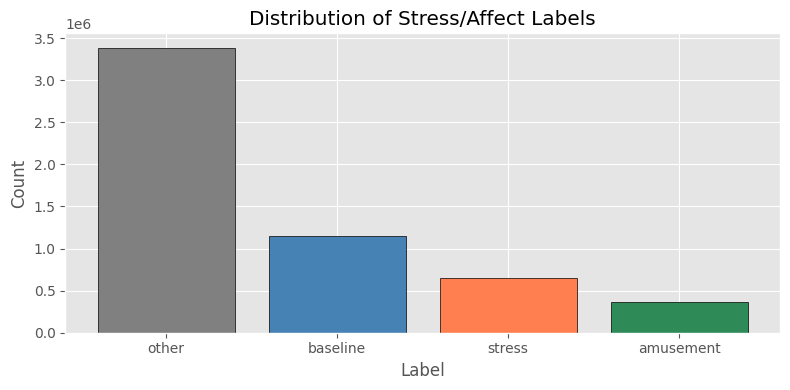

In [8]:
# Label distribution
label_counts = df['label'].value_counts().sort_index()
label_names = {-1: 'other', 0: 'baseline', 1: 'stress', 2: 'amusement'}
print('Label distribution:')
for k, v in label_counts.items():
    print(f'  {label_names.get(k, k)} ({k}): {v:,} ({100*v/len(df):.1f}%)')
print(f'\nThree-class (0,1,2) samples: {(df["label"] >= 0).sum():,}')

fig, ax = plt.subplots(figsize=(8, 4))
labels_sorted = sorted(label_counts.index)
colors = ['gray', 'steelblue', 'coral', 'seagreen']
ax.bar([label_names.get(l, str(l)) for l in labels_sorted], 
       [label_counts[l] for l in labels_sorted], 
       color=[colors[i] for i in range(len(labels_sorted))], edgecolor='black')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Distribution of Stress/Affect Labels')
plt.tight_layout()
plt.show()

### BVP and EDA by Label

Compare signal statistics across stress conditions.

BVP and EDA statistics by label:
          bvp              eda        
         mean      std    mean     std
label                                 
0      0.0053  54.8497  1.2721  1.6676
1      0.0140  82.9831  3.4541  3.6590
2      0.0136  55.7918  1.3682  1.7204


/var/folders/j_/2nhf1vq11vx6vp8923wmdmx40000gn/T/ipykernel_12009/3093577006.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)
/var/folders/j_/2nhf1vq11vx6vp8923wmdmx40000gn/T/ipykernel_12009/3093577006.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)


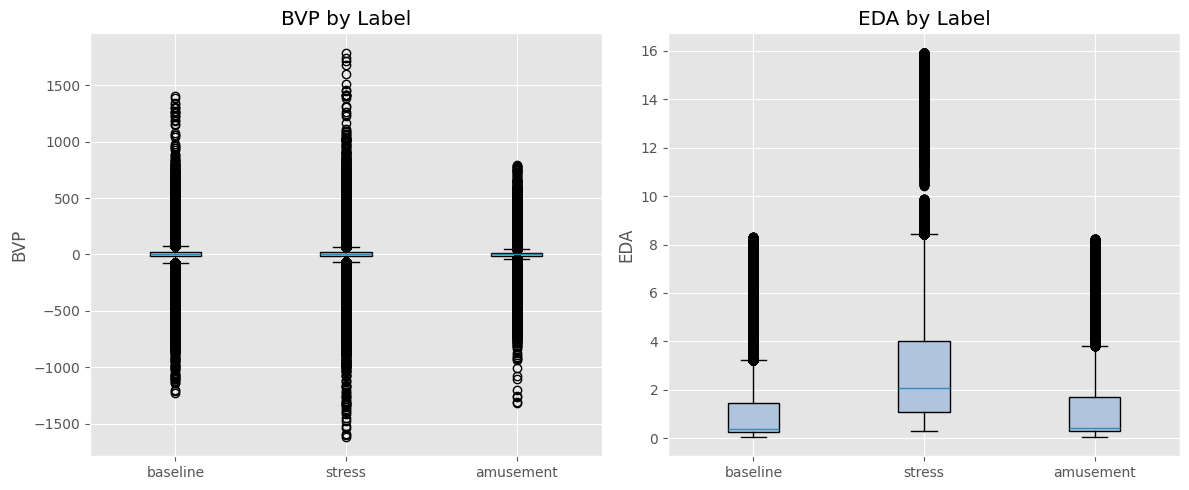

In [9]:
# Filter to three-class labels (exclude -1) for cleaner comparison
df_labels = df[df['label'] >= 0].copy()
df_labels['label_name'] = df_labels['label'].map(label_names)

# Per-label statistics
agg_label = df_labels.groupby('label').agg({'bvp': ['mean', 'std'], 'eda': ['mean', 'std']})
print('BVP and EDA statistics by label:')
print(agg_label.round(4))

# Boxplots by label (order: baseline, stress, amusement)
order = ['baseline', 'stress', 'amusement']
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in zip(axes, ['bvp', 'eda']):
    data_by_label = [df_labels[df_labels['label'] == k][col] for k in [0, 1, 2]]
    bp = ax.boxplot(data_by_label, labels=order, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightsteelblue')
    ax.set_title(f'{col.upper()} by Label')
    ax.set_ylabel(col.upper())
plt.tight_layout()
plt.show()

## 2. Missing Values

In [10]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

,Missing Count,Missing %
subject,0,0.0
time_sec,0,0.0
bvp,0,0.0
eda,0,0.0
label,0,0.0


## 3. Statistical Summary

In [11]:
df.describe(include='all')

,subject,time_sec,bvp,eda,label
count,5559552,5.559552e+06,5.559552e+06,5.559552e+06,5.559552e+06
unique,15,NaN,NaN,NaN,NaN
top,S6,NaN,NaN,NaN,NaN
freq,452544,NaN,NaN,NaN,NaN
mean,NaN,2.921036e+03,1.968015e-03,1.801766e+00,-3.582729e-01
std,NaN,1.717374e+03,6.516624e+01,2.343230e+00,9.300379e-01
min,NaN,0.000000e+00,-1.773760e+03,4.511300e-02,-1.000000e+00
25%,NaN,1.447797e+03,-1.493000e+01,3.361500e-01,-1.000000e+00
50%,NaN,2.895594e+03,2.120000e+00,8.309801e-01,-1.000000e+00
75%,NaN,4.343391e+03,1.622000e+01,2.396007e+00,0.000000e+00


## 4. Subject Distribution

In [12]:
subject_counts = df['subject'].value_counts().sort_index()
print('Number of unique subjects:', df['subject'].nunique())
print('\nRows per subject:')
print(subject_counts)
print('\nDuration per subject (approx minutes, at 64 Hz):')
for subj in subject_counts.index:
    n = subject_counts[subj]
    dur_min = n / 64 / 60
    print(f'  {subj}: {dur_min:.1f} min ({n:,} samples)')

Number of unique subjects: 15

Rows per subject:
subject
S10    351744
S11    334912
S13    354368
S14    355072
S15    336128
S16    360384
S17    378880
S2     389056
S3     415552
S4     411072
S5     400512
S6     452544
S7     335232
S8     349824
S9     334272
Name: count, dtype: int64

Duration per subject (approx minutes, at 64 Hz):
  S10: 91.6 min (351,744 samples)
  S11: 87.2 min (334,912 samples)
  S13: 92.3 min (354,368 samples)
  S14: 92.5 min (355,072 samples)
  S15: 87.5 min (336,128 samples)
  S16: 93.8 min (360,384 samples)
  S17: 98.7 min (378,880 samples)
  S2: 101.3 min (389,056 samples)
  S3: 108.2 min (415,552 samples)
  S4: 107.0 min (411,072 samples)
  S5: 104.3 min (400,512 samples)
  S6: 117.8 min (452,544 samples)
  S7: 87.3 min (335,232 samples)
  S8: 91.1 min (349,824 samples)
  S9: 87.0 min (334,272 samples)


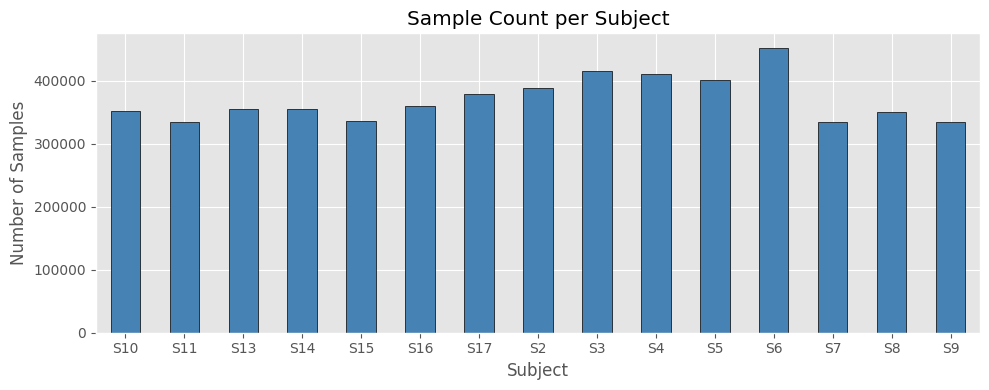

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
subject_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Sample Count per Subject')
ax.set_xlabel('Subject')
ax.set_ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 5. Univariate Distributions

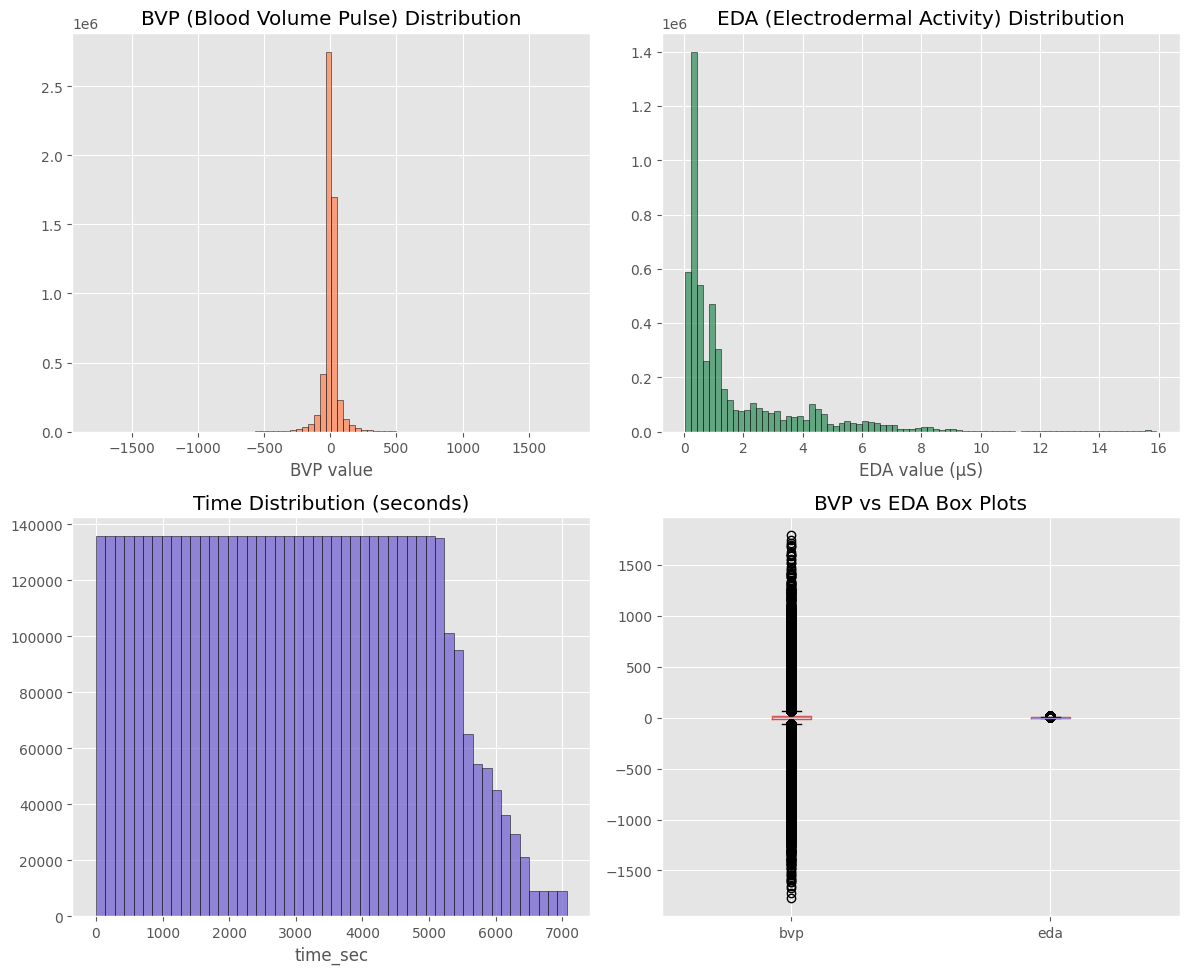

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# BVP histogram
axes[0, 0].hist(df['bvp'].dropna(), bins=80, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('BVP (Blood Volume Pulse) Distribution')
axes[0, 0].set_xlabel('BVP value')

# EDA histogram
axes[0, 1].hist(df['eda'].dropna(), bins=80, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('EDA (Electrodermal Activity) Distribution')
axes[0, 1].set_xlabel('EDA value (µS)')

# Time distribution
axes[1, 0].hist(df['time_sec'], bins=50, color='slateblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Time Distribution (seconds)')
axes[1, 0].set_xlabel('time_sec')

# Box plots for BVP and EDA
df[['bvp', 'eda']].boxplot(ax=axes[1, 1])
axes[1, 1].set_title('BVP vs EDA Box Plots')

plt.tight_layout()
plt.show()

## 6. Time Series Overview

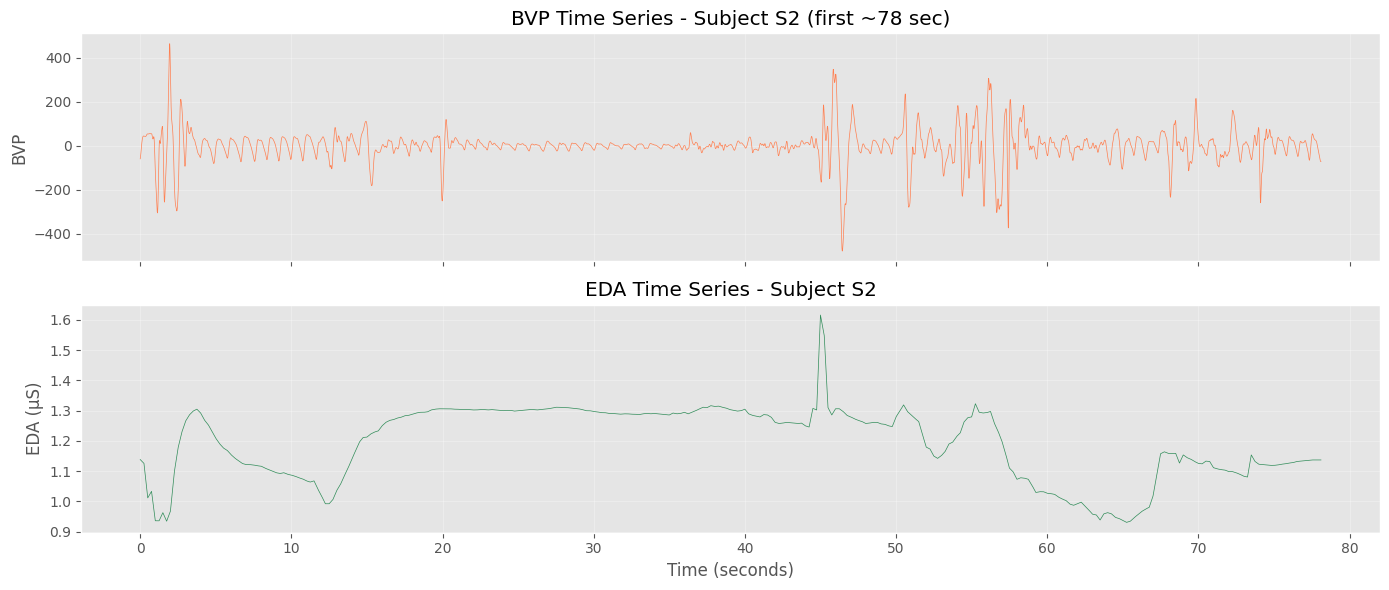

In [27]:
# Sample one subject for visualization (first 5000 points ~78 sec)
sample_subj = df['subject'].iloc[0]
sample = df[df['subject'] == sample_subj].head(5000)

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axes[0].plot(sample['time_sec'], sample['bvp'], color='coral', linewidth=0.5)
axes[0].set_ylabel('BVP')
axes[0].set_title(f'BVP Time Series - Subject {sample_subj} (first ~78 sec)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(sample['time_sec'], sample['eda'], color='seagreen', linewidth=0.5)
axes[1].set_ylabel('EDA (µS)')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title(f'EDA Time Series - Subject {sample_subj}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Time Series Colored by Label

BVP and EDA for one subject with segments colored by condition.

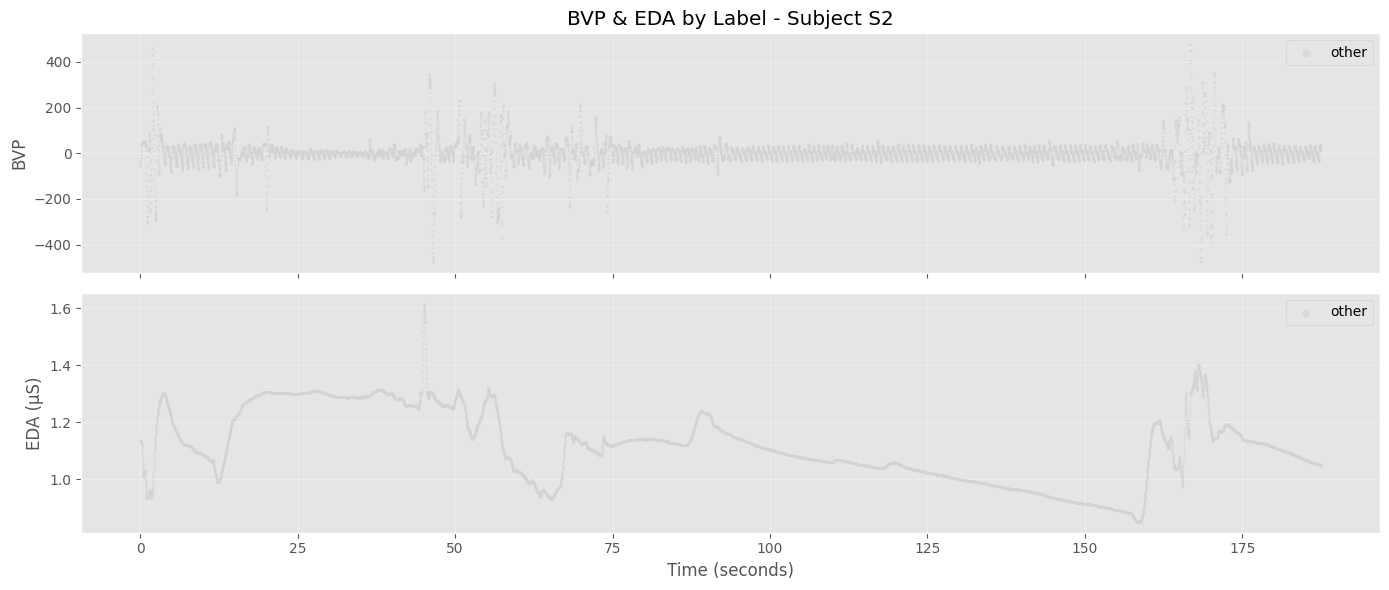

In [16]:
# Time series with label-colored segments (sample ~3 min of one subject)
sample_subj = df['subject'].iloc[0]
sample = df[df['subject'] == sample_subj].head(12000)  # ~3 min at 64 Hz

label_colors = {-1: 'lightgray', 0: 'steelblue', 1: 'coral', 2: 'seagreen'}
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for ax, col, ylab in zip(axes, ['bvp', 'eda'], ['BVP', 'EDA (µS)']):
    for lbl in [-1, 0, 1, 2]:
        mask = sample['label'] == lbl
        if mask.any():
            ax.scatter(sample.loc[mask, 'time_sec'], sample.loc[mask, col], 
                      c=label_colors[lbl], s=1, alpha=0.6, label=label_names.get(lbl, lbl))
    ax.set_ylabel(ylab)
    ax.legend(loc='upper right', markerscale=5)
    ax.grid(True, alpha=0.3)
axes[1].set_xlabel('Time (seconds)')
axes[0].set_title(f'BVP & EDA by Label - Subject {sample_subj}')
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

Correlation matrix:
          bvp       eda
bvp  1.000000  0.000105
eda  0.000105  1.000000


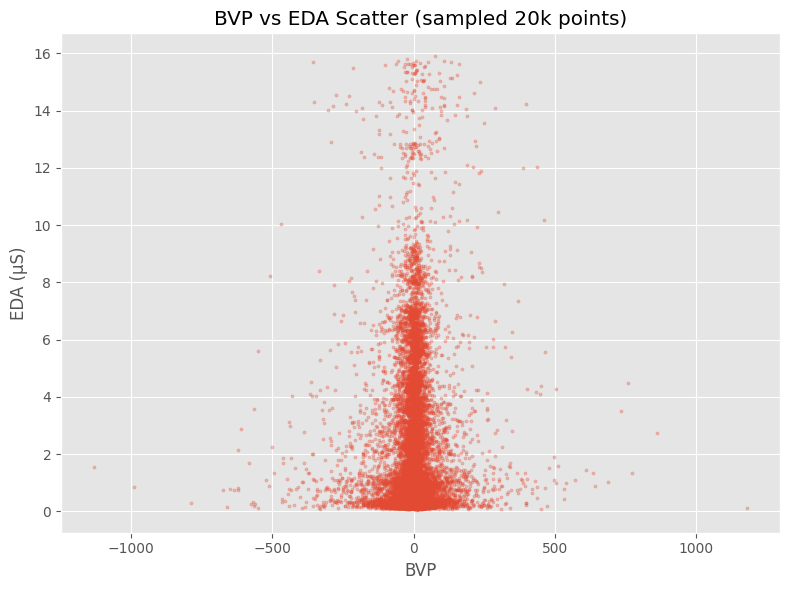

In [17]:
corr = df[['bvp', 'eda']].corr()
print('Correlation matrix:')
print(corr)

# Scatter plot (sample for readability)
sample_size = min(20000, len(df))
sample_df = df.sample(n=sample_size, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(sample_df['bvp'], sample_df['eda'], alpha=0.3, s=5)
ax.set_xlabel('BVP')
ax.set_ylabel('EDA (µS)')
ax.set_title('BVP vs EDA Scatter (sampled 20k points)')
plt.tight_layout()
plt.show()

## 8. Per-Subject Statistics

In [18]:
agg = df.groupby('subject').agg({
    'bvp': ['mean', 'std', 'min', 'max', 'median'],
    'eda': ['mean', 'std', 'min', 'max', 'median']
}).round(4)
agg

bvp                                        eda                  \
           mean       std      min      max median    mean     std     min   
subject                                                                      
S10      0.0005   46.2525  -609.23   779.69   2.53  0.9815  0.7667  0.2663   
S11      0.0016   42.0185  -561.91   630.13   1.39  3.1848  0.8552  1.8428   
S13      0.0043   89.7260 -1331.36  1044.18   5.08  7.0934  3.4431  2.8413   
S14      0.0112   42.5947  -719.36   383.93   3.64  0.3143  0.0252  0.0604   
S15     -0.0002   67.4665 -1056.42  1064.00   2.39  0.6351  0.3636  0.1512   
S16      0.0011   29.8013  -471.51   519.63   1.41  0.7162  0.5712  0.2431   
S17      0.0014   48.0894  -793.24   833.93   1.17  1.0803  0.2478  0.6426   
S2      -0.0004   75.8713  -873.67   988.08   3.01  0.3917  0.3291  0.0451   
S3      -0.0001   30.3381  -815.51   931.96   1.01  1.2314  1.6452  0.2924   
S4       0.0055   75.7704 -1500.29  1245.13   5.28  0.4752  0.6895  0.0988   
S5      -0.0007  125.7697 -1773.76  1789.00   1.89  1.5990  0.9337  0.3520   
S6       0.0047   48.8709  -962.66   989.96   2.53  3.3537  2.5798  0.1985   
S7       0.0015   36.9171  -650.81   716.57   1.14  5.2295  1.0609  3.6870   
S8      -0.0006   74.9876 -1385.41  1330.79   4.44  0.4014  0.2170  0.2049   
S9      -0.0009   60.4152 -1611.32   970.80   3.39  0.5619  0.2907  0.0553   

                          
             max  median  
subject                   
S10       3.5075  0.4723  
S11       6.0955  2.9115  
S13      15.9215  6.0348  
S14       1.0339  0.3150  
S15       1.6430  0.5441  
S16       2.6562  0.4617  
S17       2.5858  1.0159  
S2        1.7174  0.2360  
S3        8.7923  0.4700  
S4        3.1190  0.1825  
S5        4.7386  1.2282  
S6        9.8619  2.4917  
S7        8.1737  4.6985  
S8        1.2821  0.2900  
S9        1.7439  0.4531

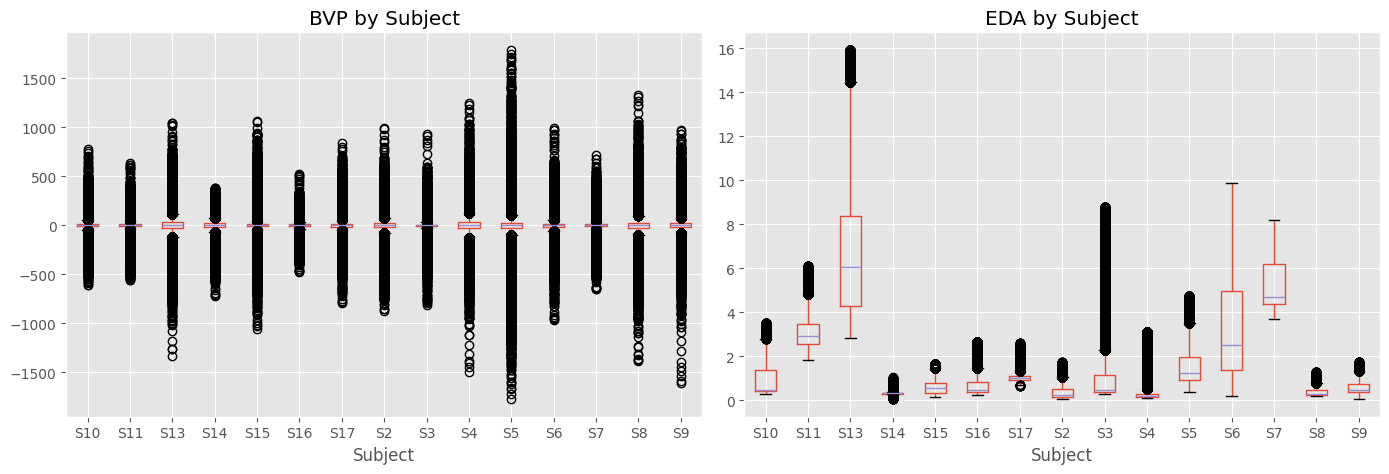

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='bvp', by='subject', ax=axes[0])
axes[0].set_title('BVP by Subject')
axes[0].set_xlabel('Subject')

df.boxplot(column='eda', by='subject', ax=axes[1])
axes[1].set_title('EDA by Subject')
axes[1].set_xlabel('Subject')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 9. Outlier Detection

In [20]:
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

bvp_out = iqr_outliers(df['bvp'])
eda_out = iqr_outliers(df['eda'])

print('BVP outliers (IQR method):', bvp_out.sum(), f'({bvp_out.sum()/len(df)*100:.2f}%)')
print('EDA outliers (IQR method):', eda_out.sum(), f'({eda_out.sum()/len(df)*100:.2f}%)')
print('\nBVP outlier bounds:', df['bvp'].quantile(0.25) - 1.5*(df['bvp'].quantile(0.75)-df['bvp'].quantile(0.25)), 'to',
      df['bvp'].quantile(0.75) + 1.5*(df['bvp'].quantile(0.75)-df['bvp'].quantile(0.25)))
print('EDA outlier bounds:', df['eda'].quantile(0.25) - 1.5*(df['eda'].quantile(0.75)-df['eda'].quantile(0.25)), 'to',
      df['eda'].quantile(0.75) + 1.5*(df['eda'].quantile(0.75)-df['eda'].quantile(0.25)))

BVP outliers (IQR method): 727349 (13.08%)
EDA outliers (IQR method): 459628 (8.27%)

BVP outlier bounds: -61.654999999999994 to 62.94499999999999
EDA outlier bounds: -2.7536355 to 5.4857925000000005


## 10. Sampling Rate Verification

In [21]:
# Verify 64 Hz: delta should be ~1/64 sec
sample = df[df['subject'] == df['subject'].iloc[0]].head(100)
deltas = sample['time_sec'].diff().dropna()
print('Expected sampling interval: 1/64 =', 1/64, 'sec')
print('Observed mean interval:', deltas.mean(), 'sec')
print('Observed std of intervals:', deltas.std(), 'sec')
print('Implied sampling rate:', 1/deltas.mean(), 'Hz')

Expected sampling interval: 1/64 = 0.015625 sec
Observed mean interval: 0.015625 sec
Observed std of intervals: 0.0 sec
Implied sampling rate: 64.0 Hz
